## Ensemble Classification Pipeline Example

This notebook demonstrates how to train and evaluate a ensemble classification pipeline using:
- `EffnetClassifier`: Fine-tunes EfficientNet for image classification
- `ClipClassifier`: Uses CLIP for zero-shot inference
- `CatBoostTuner`: Trains CatBoost on deep embeddings
- `EnsembleClassifier`: Combines all models into one final classifier

## 🧪 EfficientNet Model Evaluation

Here, we load a pre-trained `EfficientNet-b0` model (`efficientnet_b0`) from disk, prepare test data loaders, and generate predictions.

Finally, we display a confusion matrix to visualize the performance of the model on the test set.

Evaluating: 100%|██████████| 63/63 [00:05<00:00, 11.16it/s]


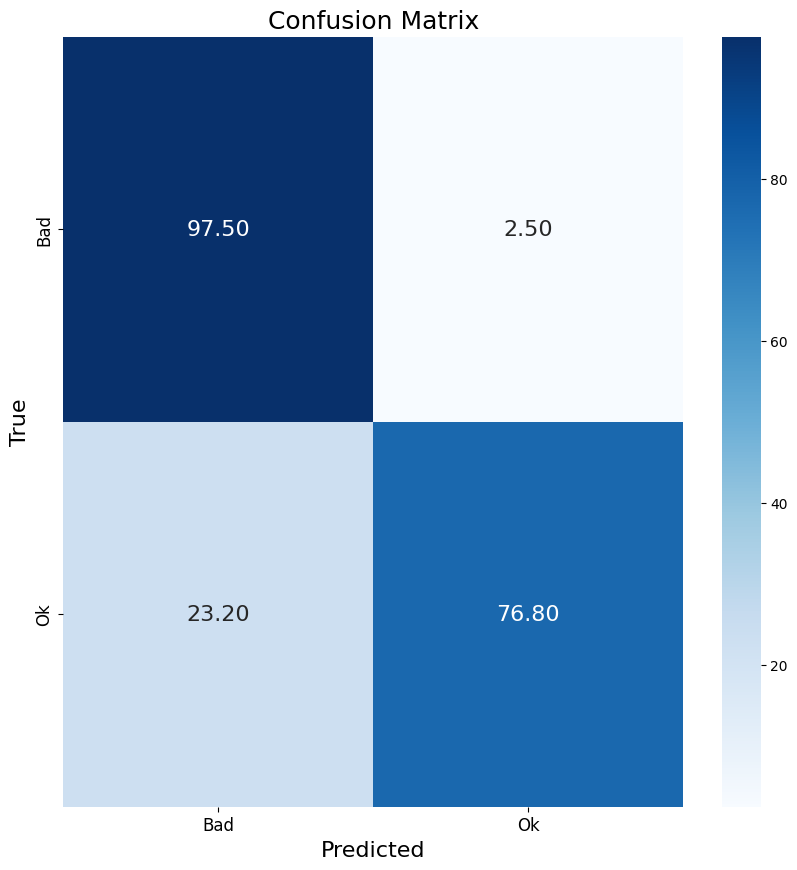

In [7]:
from classes.EffnetClassifier import EffnetClassifier
from classes.CatBoostTuner import CatBoostTuner
from classes.ClipClassifier import ClipClassifier

version = 'b0'
folder = "3Ghz"
name = f"effnet_{version}_{folder}"

model = EffnetClassifier(model_name='efficientnet_b0')
model.load_model(f"models/effnet_{version}_{folder}.pth")
model.get_efficientnet_dataloaders(data_dir=f"data/{folder}",batch_size=32)
model.confusion_matrix()

## 🚀 CatBoost Classifier Evaluation

Next, we load precomputed image embeddings stored in an `.npz` file and use them to evaluate the `CatBoostTuner` model.

This model was trained on top of the EfficientNet embeddings to improve classification accuracy.

We also generate a confusion matrix to assess its performance.

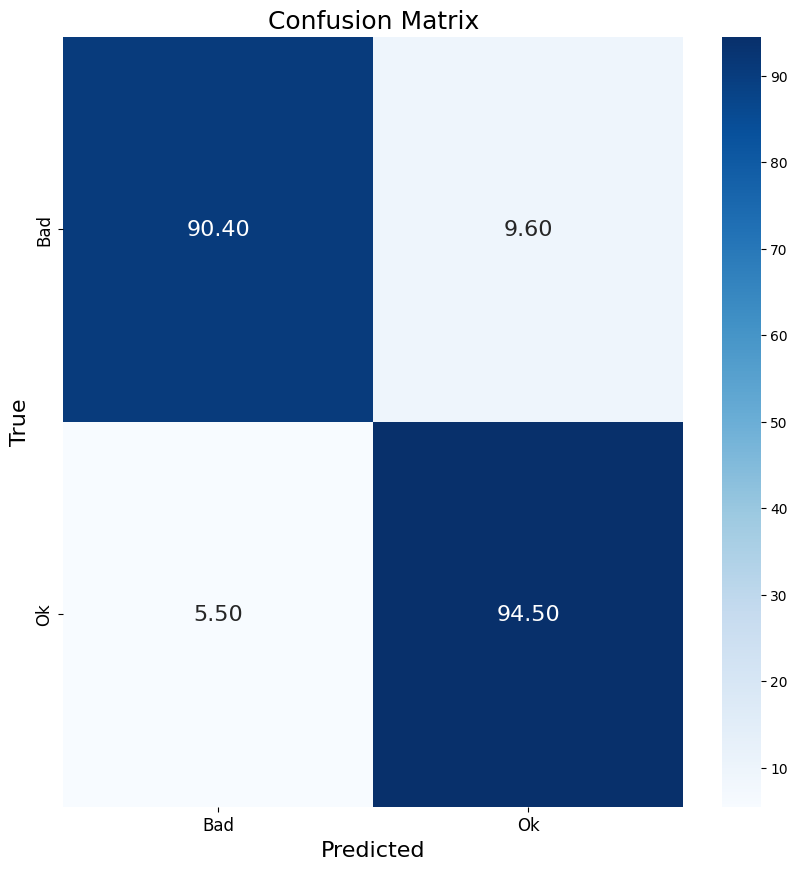

In [6]:
import numpy as np
data = np.load(f"embeddings/{name}_test.npz")
catboost_model = CatBoostTuner(data['embeddings'], data['labels'], name)
catboost_model.confusion_matrix()

## 🔍 CLIP Zero-Shot Classifier Evaluation

This section evaluates the `ClipClassifier`, which uses the CLIP model in a zero-shot fashion — meaning it can classify images without being explicitly trained on those classes.

Again, we generate a confusion matrix to analyze performance.

100%|██████████| 2000/2000 [00:33<00:00, 59.15it/s]


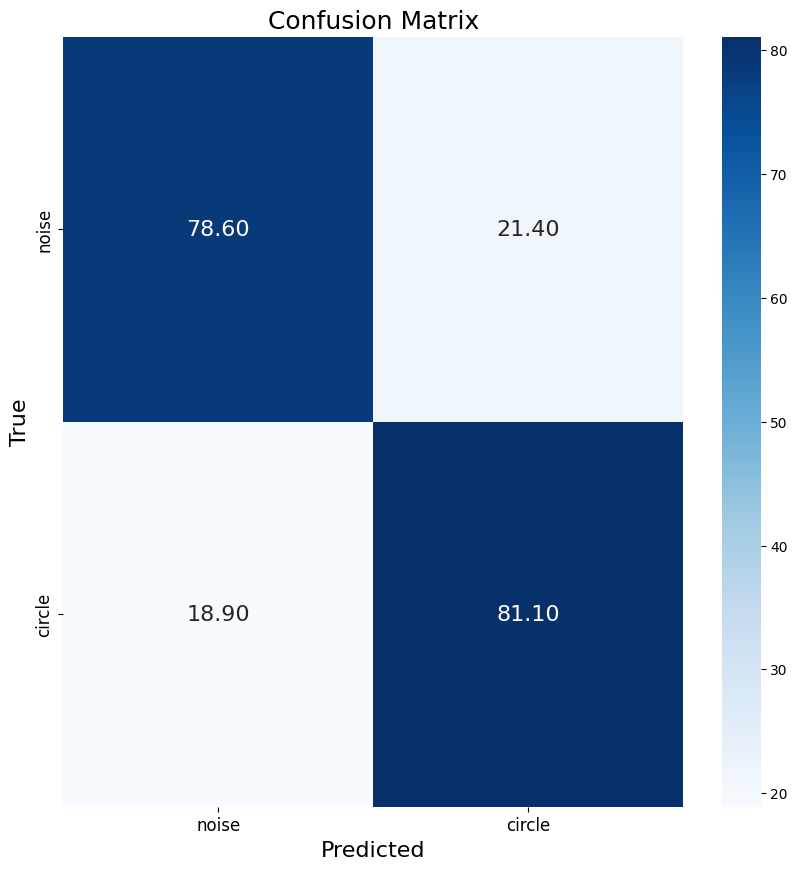

In [3]:
clip_model = ClipClassifier('test')
clip_model.confusion_matrix()

## 🤝 Ensemble Model Evaluation

Finally, we combine all three models (EfficientNet, CatBoost, and CLIP) into a single ensemble model.

We do this by:
1. Loading predictions from each individual model
2. Using `EnsembleClassifier.prepare_input()` to concatenate probabilities
3. Running the ensemble model's confusion matrix on the combined input

This gives us an overall view of how the hybrid system performs together.

Predicting on test dataset: 100%|██████████| 63/63 [00:05<00:00, 10.73it/s]


Model loaded from models/ensemble_effnet_b0_3Ghz.pth


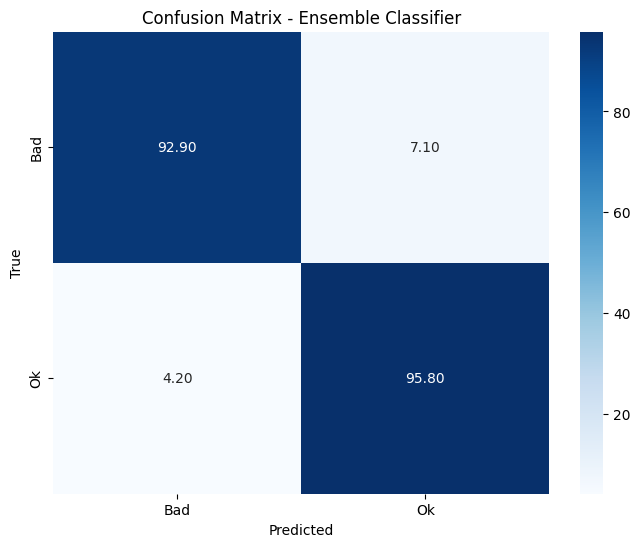

In [8]:
from classes.EnsembleClassifier import EnsembleClassifier
import numpy as np

# Load Effnet predictions
model = EffnetClassifier(model_name=f'efficientnet_{version}')
model.load_model(f"models/effnet_{version}_{folder}.pth")
model.get_efficientnet_dataloaders(data_dir=f"data/{folder}", batch_size=32)
_, effnet_probs = model.predict_from_dataloader("test")
y_true = model.get_true_classes("test")

# Load CatBoost predictions from Effnet embeddings
data = np.load(f"embeddings/{name}_test.npz")
catboost_model = CatBoostTuner(data['embeddings'], data['labels'], name)
m = catboost_model.load_model()
catboost_probs = m.predict(data['embeddings'], 'Probability')

# Load CatBoost predictions from CLIP embeddings
data = np.load(f"embeddings/clip_{folder}_test.npz")
catboost_clip_model = CatBoostTuner(data['embeddings'], data['labels'], f'clip_{folder}')
m = catboost_clip_model.load_model()
catboost_clip_probs = m.predict(data['embeddings'], 'Probability')

# Ensemble model
ensemble = EnsembleClassifier()
em = ensemble.load_model(f"models/ensemble_{name}.pth")
X = ensemble.prepare_input(effnet_probs, catboost_probs, catboost_clip_probs)
em.confusion_matrix(X, y_true)